In this notebook, I model VaR and ES for a Portfolio consisting of 5 Stocks by using two methods: Historical Simulation and Monte Carlo Simulation. I perform back-test of the model using Kupiec test. I also find the stressed VaR and stressed ES values for the Portfolio.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.stats import chi2

Download the data

In [2]:
tickers = ['AAPL', 'MSFT', 'GOOG', 'META', 'TSLA']

In [3]:
df = pd.DataFrame()
for ticker in tickers:
    data = yf.download(ticker, start='2015-01-01', end='2019-01-01',auto_adjust=True)
    df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
df

,AAPL,MSFT,GOOG,META,TSLA
Date,,,,,
2015-01-02,24.288586,39.998688,26.014021,78.021965,14.620667
2015-01-05,23.604334,39.630882,25.471745,76.768845,14.006000
2015-01-06,23.606556,39.049198,24.881382,75.734520,14.085333
2015-01-07,23.937576,39.545338,24.838757,75.734520,14.063333
2015-01-08,24.857309,40.708698,24.917074,77.753433,14.041333
...,...,...,...,...,...
2018-12-24,34.976128,88.382317,48.522579,123.383110,19.692667
2018-12-26,37.439198,94.419716,51.665890,133.447906,21.739332
2018-12-27,37.196220,95.001854,51.885582,133.786057,21.075333


Consider a Portfolio consisting of positions in 5 Stocks with equal weights. Let the total value of the Portfolio be 1 Million USD. Use the stock data for four years from 2015 to 2018. Find the VaR and ES on 2018-12-31. Choose 99% confidence level.  

In [5]:
conf_level = 0.99
portfolio_value = 1000000
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
print(weights)

[0.2 0.2 0.2 0.2 0.2]


**Finding VaR by Historical Simulation:**

Choose 500 days window for the computation.

In [6]:
window = 500

Find the daily returns for the whole Portfolio

In [7]:
returns = df.pct_change()
returns = returns.dropna()
returns

,AAPL,MSFT,GOOG,META,TSLA
Date,,,,,
2015-01-05,-0.028172,-0.009195,-0.020846,-0.016061,-0.042041
2015-01-06,0.000094,-0.014678,-0.023177,-0.013473,0.005664
2015-01-07,0.014022,0.012705,-0.001713,0.000000,-0.001562
2015-01-08,0.038422,0.029418,0.003153,0.026658,-0.001564
2015-01-09,0.001072,-0.008406,-0.012951,-0.005628,-0.018802
...,...,...,...,...,...
2018-12-24,-0.025874,-0.041739,-0.003389,-0.007123,-0.076242
2018-12-26,0.070421,0.068310,0.064780,0.081574,0.103930
2018-12-27,-0.006490,0.006165,0.004252,0.002534,-0.030544


In [8]:
window_returns = returns.iloc[-window:]
historical_returns = (window_returns * weights).sum(axis =1)

In [9]:
sorted_returns = (-historical_returns).sort_values(ascending=False)*portfolio_value
sorted_returns.iloc[:round(window*(1-conf_level))]

Date
2018-02-08    51549.908374
2018-03-27    49689.832119
2018-10-10    43012.283812
2018-10-24    41806.386349
2018-07-26    41352.721640
dtype: float64

In [10]:
VaR = sorted_returns.iloc[round(window*(1-conf_level)-1)]
VaR

41352.721640125914

In [11]:
ES = sorted_returns.iloc[:round(window*(1-conf_level))].mean()
ES

45482.22645878712

1-day 99% VaR for the Portfolio of 1 Million USD is 41352.67 USD and ES is 45482.20 USD.

Plot the distribution of Porfolio returns along with the VaR 

C:\Users\dande\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


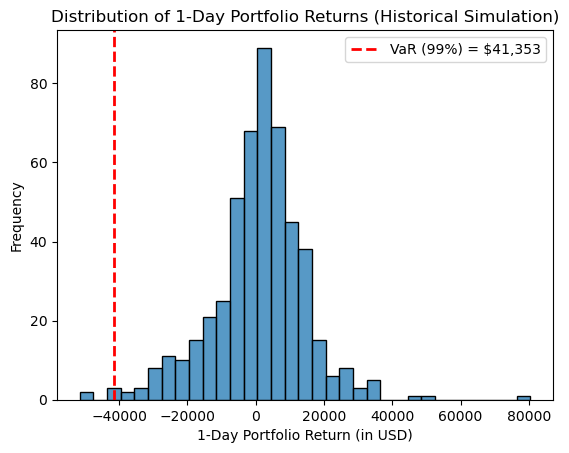

In [12]:
sns.histplot(historical_returns * portfolio_value, binwidth=4000)
plt.xlabel('1-Day Portfolio Return (in USD)')
plt.ylabel('Frequency')
plt.title('Distribution of 1-Day Portfolio Returns (Historical Simulation)')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'VaR ({conf_level:.0%}) = ${VaR:,.0f}')
plt.legend()
plt.show()

**Finding VaR by Monte Carlo Simulation:**

Find the mean returns and covariance matrix for the Stocks in the Portfolio.

In [13]:
mean_returns = window_returns.mean().values
cov_matrix = window_returns.cov().values

Perform 100000 simulations. Use random samples from multivariate normal distribution to generate the stock returns in the Portfolio.

In [14]:
n_simulations = 100000
np.random.seed(42)
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, size=n_simulations)

In [15]:
portfolio_returns = simulated_returns @ weights

In [16]:
VaR = -np.percentile(portfolio_returns, 100 - (conf_level * 100), method='closest_observation')*portfolio_value
VaR

31521.236691325677

In [17]:
sorted_returns = np.sort(-portfolio_returns*portfolio_value)
indices = np.argwhere(sorted_returns == VaR)
ES = sorted_returns[indices.flat[0]:].mean()
ES

36426.8801942019

1-day 99% VaR for the Portfolio of 1 Million USD is 31521.24 USD and ES is 36426.89 USD.

Plot the distribution of Porfolio returns along with the VaR 

C:\Users\dande\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


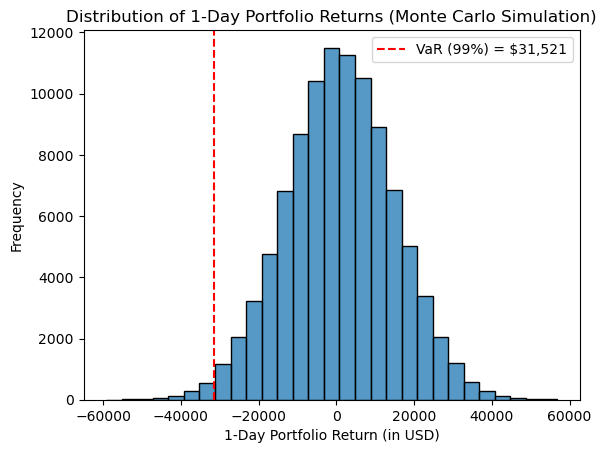

In [18]:
sns.histplot(portfolio_returns * portfolio_value, binwidth=4000)
plt.axvline(x=-VaR, color='red', linestyle='--', label=f'VaR ({conf_level:.0%}) = ${VaR:,.0f}')
plt.xlabel('1-Day Portfolio Return (in USD)')
plt.ylabel('Frequency')
plt.title('Distribution of 1-Day Portfolio Returns (Monte Carlo Simulation)')
plt.legend()
plt.show()

**Back-test the VaR models:**

Define the Kupiec test

In [19]:
def kupiec_test(var_series, actual_losses, alpha):
    N = len(actual_losses)
    p = 1 - alpha
    exceptions = np.sum(actual_losses > var_series)
    exception_rate = exceptions / N
    if exceptions == 0 or exceptions == N:
        return np.nan, np.nan, exceptions, exception_rate
    LR_pof = -2 * np.log(((1 - p)**(N - exceptions) * p**exceptions) /
                         ((1 - exception_rate)**(N - exceptions) * exception_rate**exceptions))
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    return LR_pof, p_value, exceptions, exception_rate

Perform back-test of the VaR model for last 500 days using Monte Carlo simulation. 

In [20]:
var_list = []
actual_list = []
dates = []

In [21]:
for t in range(window, len(returns) - 1):
    hist_returns = returns.iloc[t - window:t]
    mu = hist_returns.mean().values
    cov = hist_returns.cov().values
    
    sim_returns = np.random.multivariate_normal(mu, cov, size=n_simulations)
    portf_returns = sim_returns @ weights
    var = -np.percentile(portf_returns, 100 * (1 - conf_level), method='closest_observation')*portfolio_value

    actual_return = returns.iloc[t + 1].values @ weights

    var_list.append(var)
    actual_list.append(-actual_return*portfolio_value)
    dates.append(returns.index[t + 1])

In [22]:
var_df = pd.DataFrame({
    'VaR': var_list,
    'Actual Loss': actual_list
}, index=pd.to_datetime(dates))

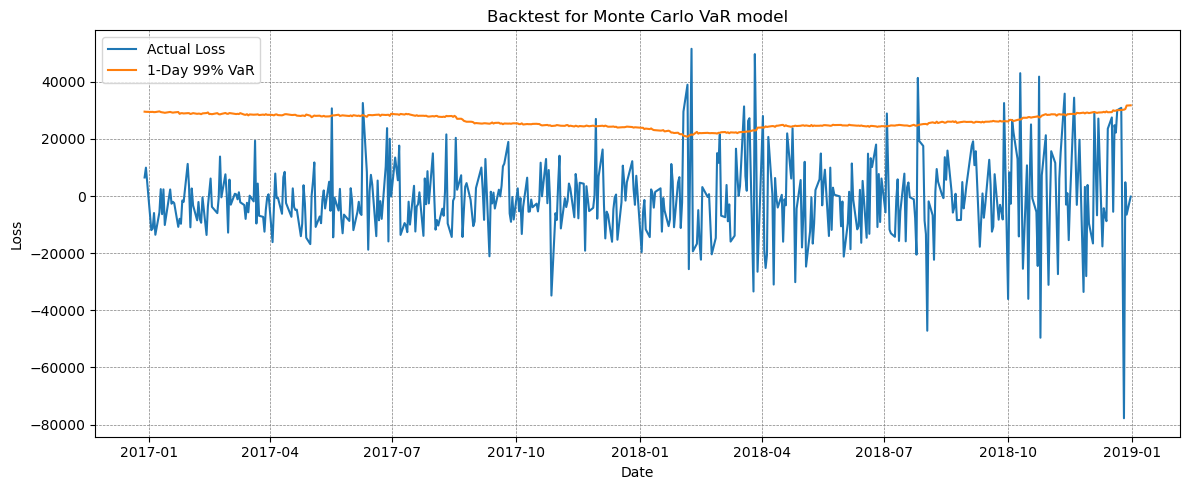

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(var_df.index, var_df['Actual Loss'], label='Actual Loss')
plt.plot(var_df.index, var_df['VaR'],  label=f'1-Day {int(conf_level*100)}% VaR')
plt.title("Backtest for Monte Carlo VaR model")
plt.xlabel("Date")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

The model is not acceptable according to the Kupiec test

In [24]:
lr_stat, p_val, n_ex, ex_rate = kupiec_test(var_df['VaR'].values, var_df['Actual Loss'].values, alpha=conf_level)
print(f"Exceptions: {n_ex} / {len(var_df)}")
print(f"Observed exception rate: {ex_rate:.4%}")
print(f"LR statistic: {lr_stat:.4f}")
print(f"P-value: {p_val:.4f}")

Exceptions: 20 / 504
Observed exception rate: 3.9683%
LR statistic: 25.6661
P-value: 0.0000


Now back-test the VaR model for last 500 days using Historical simulation. 

In [25]:
var_list = []
actual_list = []
dates = []

In [26]:
for t in range(window, len(returns) - 1):
    hist_returns = returns.iloc[t - window:t]

    historical_returns = (hist_returns * weights).sum(axis =1)
    var = -np.percentile(historical_returns, 100 - (conf_level * 100), method='closest_observation')*portfolio_value
    actual_return = returns.iloc[t + 1].values @ weights
    
    var_list.append(var)
    actual_list.append(-actual_return*portfolio_value)
    dates.append(returns.index[t + 1])

In [27]:
var_df = pd.DataFrame({
    'VaR': var_list,
    'Actual Loss': actual_list
}, index=pd.to_datetime(dates))

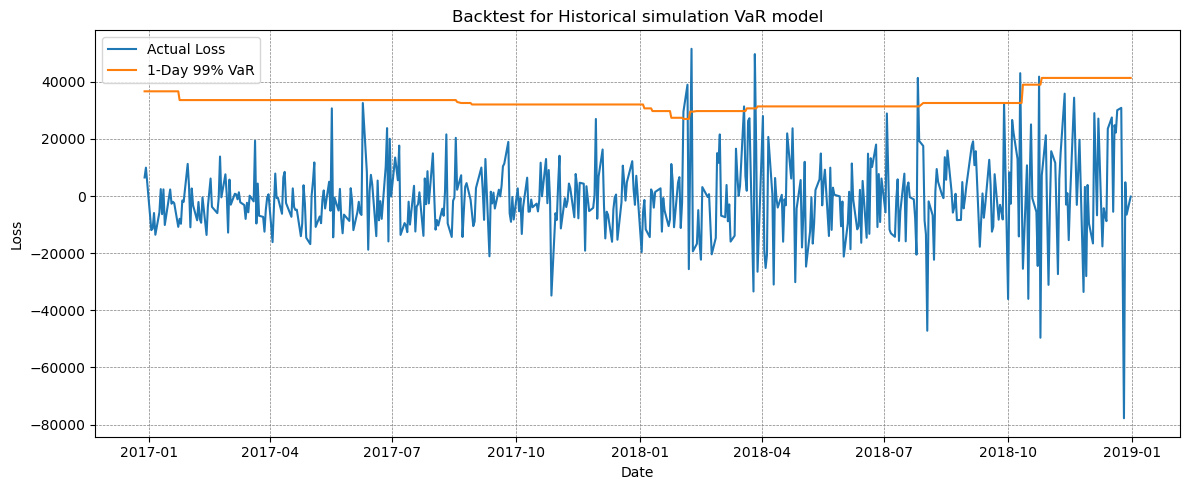

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(var_df.index, var_df['Actual Loss'], label='Actual Loss')
plt.plot(var_df.index, var_df['VaR'],  label=f'1-Day {int(conf_level*100)}% VaR')
plt.title("Backtest for Historical simulation VaR model")
plt.xlabel("Date")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5, color='gray')
plt.show()

The model is acceptable according to the Kupiec test

In [29]:
lr_stat, p_val, n_ex, ex_rate = kupiec_test(var_df['VaR'].values, var_df['Actual Loss'].values, alpha=conf_level)
print(f"Exceptions: {n_ex} / {len(var_df)}")
print(f"Observed exception rate: {ex_rate:.4%}")
print(f"LR statistic: {lr_stat:.4f}")
print(f"P-value: {p_val:.4f}")

Exceptions: 8 / 504
Observed exception rate: 1.5873%
LR statistic: 1.4902
P-value: 0.2222


**Stressed VaR using 2020 data**

In [30]:
dfs = pd.DataFrame()
for ticker in tickers:
    datas = yf.download(ticker, start='2020-01-01', end='2020-12-31',auto_adjust=True)
    dfs[ticker] = datas['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [31]:
returnss = dfs.pct_change()
returnss = returnss.dropna()
returnss

,AAPL,MSFT,GOOG,META,TSLA
Date,,,,,
2020-01-03,-0.009722,-0.012452,-0.004907,-0.005291,0.029633
2020-01-06,0.007968,0.002585,0.024657,0.018834,0.019255
2020-01-07,-0.004703,-0.009118,-0.000624,0.002164,0.038801
2020-01-08,0.016086,0.015928,0.007880,0.010138,0.049205
2020-01-09,0.021241,0.012493,0.011044,0.014311,-0.021945
...,...,...,...,...,...
2020-12-23,-0.006976,-0.013039,0.005152,0.003819,0.008808
2020-12-24,0.007712,0.007828,0.003735,-0.002648,0.024443
2020-12-28,0.035766,0.009921,0.021417,0.035901,0.002901


Historical Simulation

In [32]:
window=251

In [33]:
historical_returns = (returnss * weights).sum(axis =1)

In [34]:
sorted_returns = (-historical_returns).sort_values(ascending=False)*portfolio_value
sorted_returns

Date
2020-03-16    143070.625086
2020-03-12     97017.540604
2020-03-09     82079.923814
2020-09-08     81960.786998
2020-02-27     71129.916403
                  ...      
2020-03-10    -61281.035556
2020-03-02    -66130.922444
2020-04-06    -78385.961625
2020-03-13    -86698.571829
2020-03-24   -102935.143056
Length: 251, dtype: float64

In [35]:
VaR = sorted_returns.iloc[round(window*(1-conf_level)-1)]
VaR

82079.92381433824

In [36]:
ES = sorted_returns.iloc[:round(window*(1-conf_level))].mean()
ES

107389.36316817865

1-day 99% stressed VaR for the Portfolio of 1 Million USD is 82079.99 USD and stressed ES is 107389.41 USD.

C:\Users\dande\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


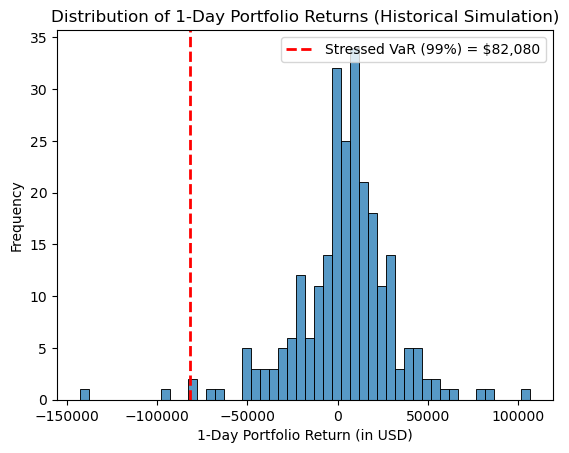

In [37]:
sns.histplot(historical_returns * portfolio_value, binwidth=5000)
plt.xlabel('1-Day Portfolio Return (in USD)')
plt.ylabel('Frequency')
plt.title('Distribution of 1-Day Portfolio Returns (Historical Simulation)')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'Stressed VaR ({conf_level:.0%}) = ${VaR:,.0f}')
plt.legend()
plt.show()

Monte Carlo Simulation

In [38]:
mean_returns = returnss.mean().values
cov_matrix = returnss.cov().values

Perform 100000 simulations. Use random samples from multivariate normal distribution for the stocks in the Portfolio.

In [39]:
n_simulations = 100000
np.random.seed(42)
simulated_returns = np.random.multivariate_normal(mean_returns, cov_matrix, size=n_simulations)

Find the Portfolio returns. Find VaR using the value at 99 percentile of the distribution of Portfolio returns. 1-day 99% VaR for the Portfolio of 1 Million USD is 48,213.21 USD.

In [40]:
portfolio_returns = simulated_returns @ weights
percentile = np.percentile(portfolio_returns, 100 - (conf_level * 100), method='closest_observation')
VaR = portfolio_value * -percentile
print(VaR)

61072.47846532749


In [41]:
sorted_returns = np.sort(-portfolio_returns*portfolio_value)
indices = np.argwhere(sorted_returns == VaR)
ES = sorted_returns[indices.flat[0]:].mean()
ES

70253.18851029011

1-day 99% stressed VaR for the Portfolio of 1 Million USD is 61072.52 USD and stressed ES is 70253.23 USD.

C:\Users\dande\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


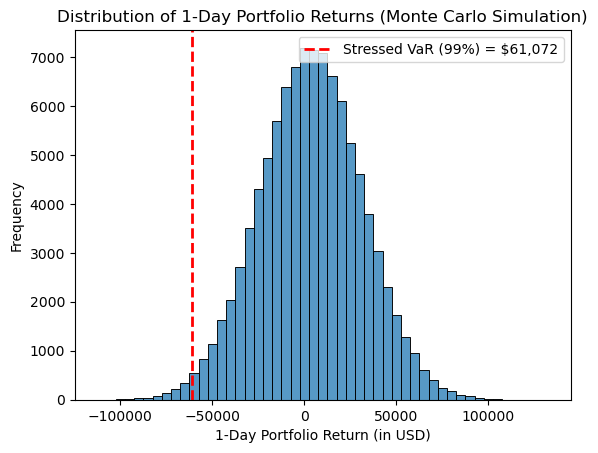

In [42]:
sns.histplot(portfolio_returns * portfolio_value, binwidth=5000)
plt.xlabel('1-Day Portfolio Return (in USD)')
plt.ylabel('Frequency')
plt.title('Distribution of 1-Day Portfolio Returns (Monte Carlo Simulation)')
plt.axvline(-VaR, color='r', linestyle='dashed', linewidth=2, label=f'Stressed VaR ({conf_level:.0%}) = ${VaR:,.0f}')
plt.legend()
plt.show()